In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/sample_submission.csv
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy
/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-06-01 22:43:28.951227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748817809.278988      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748817809.372435      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#загрузка данных

images = np.load('/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images.npy')
labels = np.load('/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/labels.npy')
images_sub = np.load('/kaggle/input/mipt-dl-captcha-2025/mds-misis-dl-captchan/images_sub.npy') # Тестовый набор для предсказания


In [4]:
# Нормализация пикселей [0, 255] -> [0, 1]
images = images.astype('float32') / 255.0
images_sub = images_sub.astype('float32') / 255.0

In [5]:
print(f"Размер обучающих изображений: {images.shape}")
print(f"Размер меток: {labels.shape}")
print(f"Размер тестовых изображений: {images_sub.shape}")

Размер обучающих изображений: (20000, 48, 48, 3)
Размер меток: (20000,)
Размер тестовых изображений: (50000, 48, 48, 3)


In [6]:
# Проверка типа данных и диапазона
print(f"Диапазон пикселей после нормализации: {images.min()} - {images.max()}")

Диапазон пикселей после нормализации: 0.0 - 1.0


In [7]:
num_classes = 26 # Количество букв в английском алфавите
labels_one_hot = to_categorical(labels, num_classes=num_classes)
print(f"Размер меток после One-Hot Encoding: {labels_one_hot.shape}")

Размер меток после One-Hot Encoding: (20000, 26)


Размер обучающей выборки (X_train): (17000, 48, 48, 3)
Размер валидационной выборки (X_val): (3000, 48, 48, 3)

Примеры обучающих изображений:


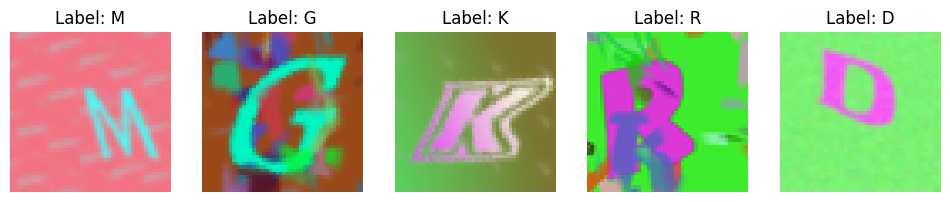

In [8]:
# 2. Разделение Данных на Обучающую и Валидационную Выборки
X_train, X_val, y_train, y_val = train_test_split(images, labels_one_hot, test_size=0.15, random_state=42) # 15% на валидацию

print(f"Размер обучающей выборки (X_train): {X_train.shape}")
print(f"Размер валидационной выборки (X_val): {X_val.shape}")

# Визуализация нескольких изображений
def plot_random_images(X, y, num_images=5):
    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        idx = np.random.randint(0, len(X))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx])
        # Преобразуем one-hot обратно в класс, а затем в букву
        label = np.argmax(y[idx])
        plt.title(f"Label: {chr(65 + label)}") # 65 - ASCII код для 'A'
        plt.axis('off')
    plt.show()

print("\nПримеры обучающих изображений:")
plot_random_images(X_train, y_train)

In [9]:
# 3. Аугментация Данных
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,          # Случайный поворот на 15 градусов
    width_shift_range=0.1,      # Случайный сдвиг по горизонтали (10% от ширины)
    height_shift_range=0.1,     # Случайный сдвиг по вертикали (10% от высоты)
    shear_range=0.1,            # Случайное срезание (наклон)
    zoom_range=0.1,             # Случайное увеличение/уменьшение
    horizontal_flip=False,      # Не переворачиваем по горизонтали
    fill_mode='nearest'         # Стратегия заполнения новых пикселей
)
# Подготовка генератора данных
datagen.fit(X_train)

In [10]:
def my_cnn(input_shape=(32, 32, 3), num_classes=26):
    model = Sequential()

    # Features (Convolutional layers)
    # Block 1
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPool2D(pool_size=(2, 2)))

    # Classifier (Dense layers)
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

model = my_cnn(input_shape=(48,48,3))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-01 22:43:55.265467: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 12, 12, 128)         │              

 Total params: 2,663,994 (10.16 MB)

 Trainable params: 2,662,074 (10.16 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [11]:
# 5. Компиляция Модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Обучение Модели
print("\nНачало обучения модели...")
# Используем early stopping для предотвращения переобучения
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Отслеживаем метрику валидационной потери
    patience=10,         # Количество эпох без улучшения, после которых обучение остановится
    restore_best_weights=True # Восстанавливаем веса лучшей эпохи
)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64), # Используем datagen для аугментации
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping] # Добавляем early stopping
)

print("\nОбучение завершено.")



Начало обучения модели...
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


266/266 ━━━━━━━━━━━━━━━━━━━━ 175s 625ms/step - accuracy: 0.0486 - loss: 3.7073 - val_accuracy: 0.0447 - val_loss: 3.2680
Epoch 2/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 163s 613ms/step - accuracy: 0.1875 - loss: 2.9244 - val_accuracy: 0.3390 - val_loss: 2.3281
Epoch 3/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 165s 618ms/step - accuracy: 0.5200 - loss: 1.5815 - val_accuracy: 0.7223 - val_loss: 0.8998
Epoch 4/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 200s 609ms/step - accuracy: 0.6676 - loss: 1.0919 - val_accuracy: 0.8193 - val_loss: 0.5598
Epoch 5/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 161s 603ms/step - accuracy: 0.7415 - loss: 0.8342 - val_accuracy: 0.8393 - val_loss: 0.5066
Epoch 6/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 158s 596ms/step - accuracy: 0.7870 - loss: 0.6797 - val_accuracy: 0.8577 - val_loss: 0.4590
Epoch 7/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 160s 600ms/step - accuracy: 0.8147 - loss: 0.5948 - val_accuracy: 0.8760 - val_loss: 0.4004
Epoch 8/20
266/266 ━━━━━━━━━━━━━━━━━━━━ 163s 611ms/step - accuracy: 0.8493 - loss: 0.48


Оценка производительности на валидационной выборке:
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9442 - loss: 0.1810
Валидационная потеря: 0.1741
Валидационная точность: 0.9457


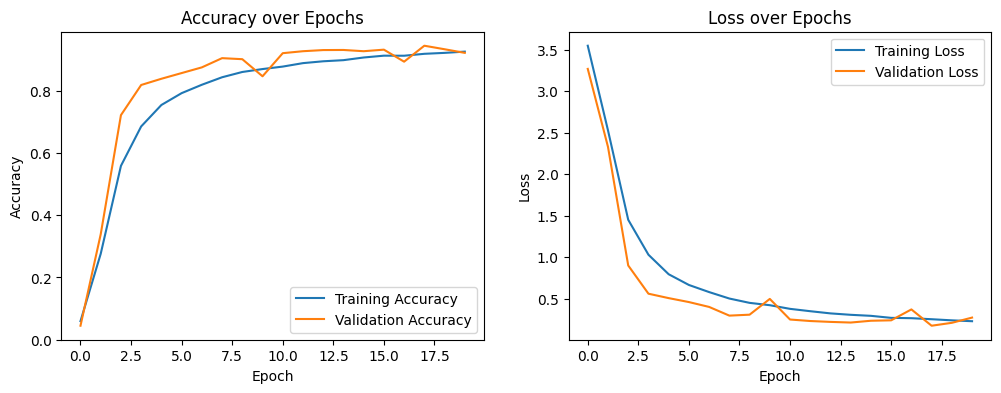

In [12]:
# 7. Оценка Производительности
print("\nОценка производительности на валидационной выборке:")
val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Валидационная потеря: {val_loss:.4f}")
print(f"Валидационная точность: {val_accuracy:.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# 8. Предсказание на Тестовом Наборе и Формирование Файла для Отправки
print("\nПредсказание на тестовом наборе (images_sub.npy)...")
predictions = model.predict(images_sub)
predicted_classes = np.argmax(predictions, axis=1)


Предсказание на тестовом наборе (images_sub.npy)...
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 107s 68ms/step


In [14]:
submission_df = pd.DataFrame({'Id': np.arange(len(predicted_classes)), 'Category': predicted_classes})
submission_df.to_csv('submission.csv', index=False)

print("\nФайл submission.csv успешно создан!")
print(submission_df.head())


Файл submission.csv успешно создан!
   Id  Category
0   0        19
1   1         8
2   2        14
3   3        12
4   4        10
